[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Цепочка (Chain)

## Итоги предыдущего шага

Мы построили простой граф с узлами, обычными и условными переходами.

## Цели текущего раздела

Теперь создадим простую цепочку, объединяющую 4 концепции:

* Использование [чат-сообщений](https://docs.langchain.com/oss/python/langchain/messages) в качестве состояния графа
* Применение [чат-моделей](https://docs.langchain.com/oss/python/integrations/chat) в узлах графа
* [Привязка инструментов](https://docs.langchain.com/oss/python/langchain/models#tool-calling) к нашей чат-модели
* [Вызов инструментов](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) в узлах графа

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_mistralai langchain_core langgraph

## Сообщения (Messages)

Чат-модели работают с [сообщениями](https://docs.langchain.com/oss/python/langchain/messages), которые отражают различные роли в диалоге.

LangChain поддерживает различные типы сообщений, включая `HumanMessage`, `AIMessage`, `SystemMessage` и `ToolMessage`.

Они представляют сообщения от пользователя, от чат-модели, инструкции для модели по изменению поведения и ответы от вызова инструментов.

Давайте создадим список сообщений.

Каждое сообщение может содержать следующие элементы:

* `content` - содержимое сообщения
* `name` - необязательное указание автора сообщения
* `response_metadata` - необязательный словарь метаданных (часто заполняется провайдером модели для `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Чат-модели

Чат-модели принимают на вход последовательность сообщений и поддерживают типы сообщений, которые мы обсудили выше.

Доступно [множество моделей](https://docs.langchain.com/oss/python/integrations/chat) на выбор! Будем работать с Mistral.

Давайте проверим, что ваша переменная `MISTRAL_API_KEY` установлена. Если нет, система запросит её ввод.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


Мы можем загрузить чат-модель и запустить её с нашим списком сообщений.

Как видно, результат представляет собой `AIMessage` с определёнными метаданными в `response_metadata`.

In [20]:
from langchain_mistralai import ChatMistralAI
llm = ChatMistralAI(model="mistral-medium-2508")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [22]:
result

AIMessage(content='If you want to see **orcas (killer whales)** in the U.S., the best places depend on the season, the type of orcas (resident, transient, or offshore), and your preferred viewing method (wild vs. captivity). Here are the **top locations** for wild orca sightings:\n\n---\n\n### **1. Pacific Northwest (Best for Wild Orcas)**\nThis is the **#1 region** for orca watching in the U.S., home to the famous **Southern Resident Orcas** (endangered) and **transient (Bigg’s) orcas**.\n\n#### **A. San Juan Islands, Washington (Best Overall Spot)**\n   - **Why?** The **Southern Resident Orcas (J, K, and L pods)** frequent these waters from **May–September**, feeding on salmon.\n   - **Best Time:** **June–August** (peak season).\n   - **How to See Them:**\n     - **Whale-watching tours** (San Juan Island, Friday Harbor, Orcas Island).\n     - **Lime Kiln Point State Park** ("Whale Watch Park") – best **land-based** spot.\n     - **Kayaking tours** (for a closer, quieter experience).\

In [23]:
result.response_metadata

{'token_usage': {'prompt_tokens': 49,
  'total_tokens': 1851,
  'completion_tokens': 1802},
 'model_name': 'mistral-medium-2508',
 'model': 'mistral-medium-2508',
 'finish_reason': 'stop',
 'model_provider': 'mistralai'}

## Инструменты (Tools)

Инструменты полезны, когда нужно, чтобы модель взаимодействовала с внешними системами.

Внешние системы (например, API) часто требуют определённую схему входных данных или структуру payload, а не просто естественный язык.

Когда мы привязываем API как инструмент, мы даём модели понимание требуемой схемы входных данных.

Модель будет решать, вызывать ли инструмент, на основе естественно-языкового ввода от пользователя.

И она вернёт результат, соответствующий схеме инструмента.

[Многие провайдеры LLM поддерживают вызов инструментов](https://docs.langchain.com/oss/python/integrations/chat), а [интерфейс вызова инструментов](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) в LangChain прост в использовании.

Вы можете просто передать любую Python-`функцию` в `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Продемонстрируем простой пример вызова инструмента!

Функция `multiply` будет нашим инструментом.

In [24]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

Если мы передадим входные данные — например, `"What is 2 multiplied by 3"` — мы увидим возвращённый вызов инструмента.

Вызов инструмента содержит конкретные аргументы, соответствующие входной схеме нашей функции, а также имя функции для вызова.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [25]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [26]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'clYs4GI3S',
  'type': 'tool_call'}]

## Использование сообщений в качестве состояния

Имея эти основы, мы теперь можем использовать [сообщения](https://docs.langchain.com/oss/python/langchain/overview#messages) в состоянии нашего графа.

Определим наше состояние `MessagesState` как `TypedDict` с единственным ключом: `messages`.

`messages` — это просто список сообщений, как мы определили выше (например, `HumanMessage` и другие).

In [27]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Редьюсеры (Reducers)

Теперь у нас есть небольшая проблема!

Как мы обсуждали, каждый узел возвращает новое значение для нашего ключа состояния `messages`.

Но это новое значение перезапишет предыдущее значение `messages`!

По мере выполнения графа мы хотим **добавлять** сообщения к нашему ключу состояния `messages`.

Для решения этой задачи мы можем использовать [функции-редьюсеры](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers).

Редьюсеры определяют, как выполняются обновления состояния.

Если функция-редьюсер не указана, предполагается, что обновления ключа должны *перезаписывать* его, как мы видели ранее.

Но для добавления сообщений мы можем использовать встроенный редьюсер `add_messages`.

Это гарантирует, что любые сообщения будут добавляться к существующему списку сообщений.

Нам просто нужно аннотировать наш ключ `messages` функцией-редьюсером `add_messages` в качестве метаданных.

In [28]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Поскольку использование списка сообщений в состоянии графа — очень распространённая практика, в LangGraph есть готовая реализация [`MessagesState`](https://docs.langchain.com/oss/python/langgraph/graph-api#messagesstate)!

`MessagesState` определяется следующим образом:

* С предустановленным ключом `messages`
* Это список объектов `AnyMessage`
* Использует редьюсер `add_messages`

Мы обычно будем использовать `MessagesState`, поскольку это менее многословно, чем определять пользовательский `TypedDict`, как показано выше.

In [29]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

Чтобы разобраться глубже, давайте посмотрим, как работает редьюсер `add_messages` изолированно.

In [30]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ebb08c74-a659-47d9-a6b1-b4cbd321796b'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='fdd52b38-514e-4c71-a246-2906d29469af'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='78847172-5022-42ea-bd1e-174f1f3a1c02')]

## Наш граф

Теперь давайте используем `MessagesState` в графе.

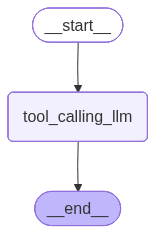

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Если мы передадим `Hello!`, языковая модель ответит без вызова каких-либо инструментов.

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today? 😊


Языковая модель решает использовать инструмент, когда определяет, что входные данные или задача требуют функциональности, предоставляемой этим инструментом.

In [35]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (YODfaBD4y)
 Call ID: YODfaBD4y
  Args:
    a: 2
    b: 3
